## Import library

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import copy as cp
import calendar

In [2]:
# 載入所需函示庫
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.libqsturng
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100

In [3]:
def strtoint(s):
   #print(s)
    if type(s) != str :
        return s
    ss = s.split(',')
    #print(ss[0])
    temp = 0
    for i in range(len(ss)):
        temp = temp * 1000 + int(ss[i])
#     temp = float(temp / 1000000)
    return temp

## Build a library

In [4]:
transportCnt = dict()

In [5]:
year = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
month = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [6]:
for i in year:
    for j in month:
        if i == '2022' and j == '04':
            break
        dt_name = '+OÑ_¦¦¦BÑ¦¿t¦+«+¦B¦q¦+¡p_' + i + j+'.csv'
        df = pd.read_csv(dt_name,encoding='big5')
        for k in range(df.shape[0]):
            tmp = df['營運日'][k]
            if(tmp != tmp):
                continue
            tmp = df['營運日'][k].split('/')
            date = datetime(int(tmp[0]) + 1911, int(tmp[1]), int(tmp[2]))
            transport = strtoint(df['總運量'][k])
            transportCnt.setdefault(date,transport)

## Functions

In [7]:
def getHoliday(year, Holiday, df):
    name = []
    y = year
    i = year - 2005
    if(type(df[Holiday][i]) == datetime):
        name.append(df[Holiday][i])
    else:
        start, end = df[Holiday][i].split('-')
        start = start.split('/')
        start = [int(s) for s in start]
        end = end.split('/')
        end = [int(s) for s in end]

        if(start[0] == end[0]):
            name += [datetime(y, start[0], x) for x in np.arange(start[1], end[1] + 1, 1)]
        else:
            lastday = calendar.monthrange(y, start[0])[1]
            if(start[0] == 12):
                name += [datetime(y - 1, start[0], x) for x in np.arange(start[1], lastday + 1, 1)]
                name += [datetime(y, end[0], x) for x in np.arange(1, end[1] + 1, 1)]
            else:
                name += [datetime(y, start[0], x) for x in np.arange(start[1], lastday + 1, 1)]
    return name

In [8]:
def getHolidayLength(date):
    holiday, column, i = isHoliday([date.year], h_columns, date)
    if(holiday):
        return int(df[column][i])
    elif(date.isoweekday() == 6 or date.isoweekday() == 7):
        return 2
    else:
        return 0

In [9]:
def isHoliday(years, columns, date):
    for column in columns:
        for year in years:
            if(date in holiday_rec[column][year - 2005]):
                return True, column, year - 2005
    return False, -1, -1

In [10]:
def holiday_type(date):
    y = date.year
    m = date.month
    d = date.day
    traditional = ['春節', '端午', '中秋']
    national = ['雙十', '二二八', '元旦', '清明', '勞動']
    years = np.arange(2015, 2023, 1)
    if(isHoliday(years, traditional, date)[0]):
        return 'Traditional'
    elif(isHoliday(years, national, date)[0]):
        return 'National'
    elif((m == 12 and d == 25) or (m == 2 and d == 14) or (m == 10 and d == 31)):
        return 'Western'
    elif((m == 8 and d == 8) or (m == 5 and d <= 14 and d >= 8 and date.isoweekday() == 7)):
        return 'Fother'
    elif(date.isoweekday() == 6 or date.isoweekday() == 7):
        return 'Weekend'
    else:
        return 'Weekday'

## Global

In [11]:
df = pd.read_excel('../歷年連假天數.xlsx')
columns = ['春節.1', '端午.1', '中秋.1', '雙十.1', '二二八.1', '元旦.1', '清明.1', '勞動.1']
years = np.arange(2005, 2023, 1)
holiday_rec = []
for column in columns:
    tmp = []
    for year in years:
        tmp.append(getHoliday(year, column, df))
    holiday_rec.append(tmp)
holiday_rec = pd.DataFrame(holiday_rec).T
h_columns = ['春節', '端午', '中秋', '雙十', '二二八', '元旦', '清明', '勞動']
holiday_rec.columns = h_columns

## 日子

### Parametric - One Way Anova

$$H_0: \mu_{平日} = \mu_{一般假日} = \mu_{傳統} = \mu_{國定} = \mu_{西洋} = \mu_{X親}$$  
$$H_1: \text{one of the equality in } H_0 \text{ is not satisfied}$$

In [12]:
traditional = ['春節', '端午', '中秋']
national = ['雙十', '二二八', '元旦', '清明', '勞動']

In [13]:
days = [[]for i in range(6)]
check = [[]for i in range(6)]

In [14]:
year = np.arange(2015, 2023, 1)
month = np.arange(1, 13, 1)
for y in year:
    if(y == 2022):
        month = np.arange(1, 4, 1)
    for m in month:
        for d in np.arange(1, calendar.monthrange(y,m)[1] + 1, 1):
            today = datetime(y,m,d)
            if(isHoliday(year, traditional, today)[0]):
                days[2].append(transportCnt[today])
            elif(isHoliday(year, national, today)[0]):
                days[3].append(transportCnt[today])
            elif((m == 12 and d == 25) or (m == 2 and d == 14) or (m == 10 and d == 31)):
                days[4].append(transportCnt[today])
            elif((m == 8 and d == 8) or (m == 5 and d <= 14 and d >= 8 and today.isoweekday() == 7)):
                days[5].append(transportCnt[today])
            elif(today.isoweekday() == 6 or today.isoweekday() == 7):
                days[1].append(transportCnt[today])
            else:
                days[0].append(transportCnt[today])

In [15]:
df1 = pd.DataFrame(days).T
columns = ['Weekday', 'Weekend', 'Traditional', 'National', 'Western', 'Fother']
df1.columns = columns
df1

,Weekday,Weekend,Traditional,National,Western,Fother
0,1915326.0,1897089.0,751526.0,1796950.0,1972064.0,1514055.0
1,1945591.0,1551238.0,1342552.0,1830184.0,2025217.0,418145.0
2,1965860.0,1884434.0,1356261.0,1802037.0,2448812.0,1580602.0
3,1987913.0,1631624.0,1678593.0,1585463.0,1839311.0,2002855.0
4,2163929.0,1901482.0,1653840.0,2031991.0,2123416.0,1599230.0
...,...,...,...,...,...,...
1768,2172261.0,NaN,NaN,NaN,NaN,NaN
1769,1919316.0,NaN,NaN,NaN,NaN,NaN
1770,1940394.0,NaN,NaN,NaN,NaN,NaN
1771,1969018.0,NaN,NaN,NaN,NaN,NaN


In [16]:
df2 = pd.DataFrame(list(transportCnt.items()), columns=['Date', 'TPcnt'])
df2['Holiday_Type'] = [holiday_type(day) for day in df2['Date']]
df2['Year'] = [day.year for day in df2['Date']]
df2 = df2.drop(df2[df2['Year'] >= 2020].index)
df2

,Date,TPcnt,Holiday_Type,Year
0,2015-01-01,1796950,National,2015
1,2015-01-02,1830184,National,2015
2,2015-01-03,1802037,National,2015
3,2015-01-04,1585463,National,2015
4,2015-01-05,1915326,Weekday,2015
...,...,...,...,...
1821,2019-12-27,2658619,Weekday,2019
1822,2019-12-28,2298630,Weekend,2019
1823,2019-12-29,1777124,Weekend,2019
1824,2019-12-30,2469682,Weekday,2019


In [17]:
results = smf.ols('TPcnt ~ C(Holiday_Type)', data=df2).fit()
# results.summary()
aov_table = sms.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Holiday_Type),5.815745e+13,5.0,294.322585,4.123575e-231
Residual,7.192554e+13,1820.0,NaN,NaN


In [18]:
mc = smm.MultiComparison(df2['TPcnt'], df2['Holiday_Type'])
print(mc.tukeyhsd().summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
   group1      group2     meandiff   p-adj     lower        upper     reject
----------------------------------------------------------------------------
     Fother    National  139497.5889 0.2986  -51886.3381  330881.5159  False
     Fother Traditional -192335.0273 0.0502 -384776.9166      106.862  False
     Fother     Weekday  503335.5738  0.001  323267.2077  683403.9399   True
     Fother     Weekend  213750.4725 0.0102   32407.2935  395093.6516   True
     Fother     Western  530156.6286  0.001  295352.1444  764961.1127   True
   National Traditional -331832.6162  0.001  -428474.661 -235190.5713   True
   National     Weekday  363837.9849  0.001   295059.932  432616.0378   True
   National     Weekend   74252.8836  0.039    2203.2294  146302.5379   True
   National     Western  390659.0397  0.001  225011.9755  556306.1039   True
Traditional     Weekday   695670.601  0.001  624001.2644  767339.9377   True

D:\New folder\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


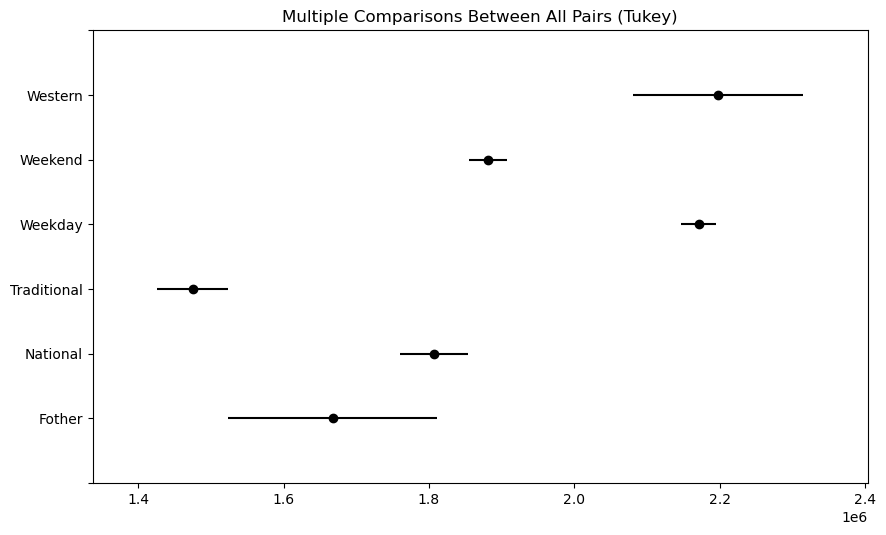

In [19]:
_ = mc.tukeyhsd().plot_simultaneous()

### Required Condition

#### Check normality assumption - Shapiro Wilk Test

$$H_0: \text{residual of all datapoints are normally distributed}$$  
$$H_1: \text{residual of all datapoints are not normally distributed}$$  

In [20]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.8834, p=0.0000


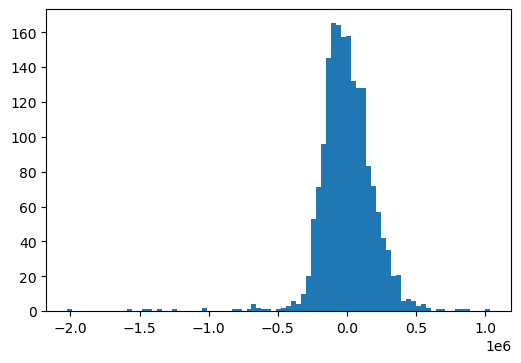

In [21]:
_ = plt.hist(results.resid, bins = "auto")

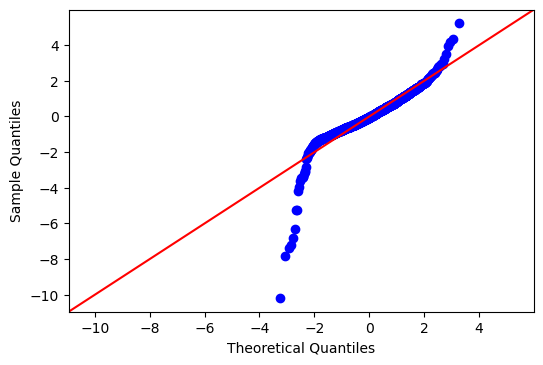

In [22]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.show()

#### Check equal variance assumption - Bartlett's Test

$$H_0: \text{Variance of different treatment groups are equal}$$  
$$H_1: \text{At least two treatment groups have different variance}$$

In [23]:
df2['resid'] = results.resid
stats.bartlett(df2['resid'][df2['Holiday_Type'] == 'Weekday'], 
               df2['resid'][df2['Holiday_Type'] == 'Weekend'], 
               df2['resid'][df2['Holiday_Type'] == 'Traditional'],
                df2['resid'][df2['Holiday_Type'] == 'National'],
                df2['resid'][df2['Holiday_Type'] == 'Western'],
              df2['resid'][df2['Holiday_Type'] == 'Fother'])

BartlettResult(statistic=83.37605738432954, pvalue=1.6482793553106593e-16)

### Nonparametric - Kruskal

In [24]:
alldata = np.array([])
for day in days:
    alldata = np.concatenate([alldata, day])
alldata.sort()
tmpdf = pd.DataFrame(({'value': alldata}))
tmpdf['rank'] = tmpdf.index + 1
value2rank = tmpdf.groupby('value').mean().reset_index()
value2rank

,value,rank
0,149936.0,1.0
1,150242.0,2.0
2,152420.0,3.0
3,160534.0,4.0
4,168154.0,5.0
...,...,...
2637,2658619.0,2643.0
2638,2668231.0,2644.0
2639,2678263.0,2645.0
2640,3028347.0,2646.0


In [25]:
T = []
for i, day in enumerate(days):
    samp = pd.DataFrame({'value': day})
    samp = pd.merge(samp, value2rank)
    T.append(samp['rank'].sum())
    print(f"T%s = {T[i]}"%(i))

T0 = 2873485.0
T1 = 494451.0
T2 = 28859.0
T3 = 66229.0
T4 = 33305.0
T5 = 8299.0


In [26]:
n = []
columns = ['Weekday', 'Weekend', 'Traditional', 'National', 'Western', 'Fother']
for column in columns:
    n.append(df1[column].dropna().shape[0])
    
T = np.array(T)
n = np.array(n)
x = T ** 2 / n
k = 6
n = n.sum()
H = 12 / (n * (n + 1)) * (x.sum()) - 3 * (n + 1)
pvalue = 1 - stats.chi2.cdf(H, k - 1)

print(f"H = {H}")
print(f"p-value = {pvalue}")

H = 875.1149296574622
p-value = 0.0


## 假期長度

### Parametric - One Way Anova

In [27]:
days_len = [[]for i in range(6)]

In [28]:
year = np.arange(2015, 2023, 1)
month = np.arange(1, 13, 1)
for y in year:
    if(y == 2022):
        month = np.arange(1, 4, 1)
    for m in month:
        for d in np.arange(1, calendar.monthrange(y,m)[1] + 1, 1):
            today = datetime(y,m,d)
            length = getHolidayLength(today)
            if(length > 4):
                days_len[5].append(transportCnt[today])
            else:
                days_len[length].append(transportCnt[today])

In [29]:
df1 = pd.DataFrame(days_len).T
columns = ['Normal', 'One', 'Two', 'Three', 'Four', 'FourPlus']
df1.columns = columns
df1

,Normal,One,Two,Three,Four,FourPlus
0,1915326.0,1402500.0,1897089.0,2031991.0,1796950.0,751526.0
1,1945591.0,1690886.0,1551238.0,2081276.0,1830184.0,1342552.0
2,1965860.0,1830443.0,1884434.0,2017620.0,1802037.0,1356261.0
3,1987913.0,1695510.0,1631624.0,1985334.0,1585463.0,1678593.0
4,2163929.0,1853602.0,1901482.0,1708675.0,1769724.0,1653840.0
...,...,...,...,...,...,...
1788,2172261.0,NaN,NaN,NaN,NaN,NaN
1789,1919316.0,NaN,NaN,NaN,NaN,NaN
1790,1940394.0,NaN,NaN,NaN,NaN,NaN
1791,1969018.0,NaN,NaN,NaN,NaN,NaN


In [30]:
# wide_to_long假設同樣資料在不同因素下的名稱有相同的字頭，因此我們要改欄位名稱。
# df1b = df1.rename(columns={'Normal': 'TPcnt_normal', "One": "TPcnt_one", 
#                           "Two": "TPcnt_two", "Three": "TPcnt_three"
#                          , "Four": "TPcnt_four", "FourPlus": "TPcnt_fourplus"})
df1b = df1.copy()
df1b.columns = ["TPcnt_" + str(column) for column in columns]
# 需要一個ID欄位
df1b["id"] = df1b.index
# 呼叫wide_to_long(); 文件請見: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html
df2 = pd.wide_to_long(df1b, ["TPcnt"], sep="_", suffix='\w+', i="id", j="Holiday_Type").dropna().reset_index()
print("Head of dataset:")
display(df2.head())
print("Tail of dataset:")
display(df2.tail())

Head of dataset:


,id,Holiday_Type,TPcnt
0,0,Normal,1915326.0
1,1,Normal,1945591.0
2,2,Normal,1965860.0
3,3,Normal,1987913.0
4,4,Normal,2163929.0


Tail of dataset:


,id,Holiday_Type,TPcnt
2642,52,FourPlus,1469423.0
2643,53,FourPlus,1386871.0
2644,54,FourPlus,981204.0
2645,55,FourPlus,733248.0
2646,56,FourPlus,525312.0


In [31]:
results = smf.ols('TPcnt ~ C(Holiday_Type)', data=df2).fit()
# results.summary()
aov_table = sms.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Holiday_Type),1.035844e+14,5.0,154.799103,1.571406e-144
Residual,3.534469e+14,2641.0,NaN,NaN


In [32]:
mc = smm.MultiComparison(df2['TPcnt'], df2['Holiday_Type'])
print(mc.tukeyhsd().summary())

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
 group1   group2    meandiff   p-adj     lower        upper     reject
----------------------------------------------------------------------
    Four FourPlus -198107.8362 0.0376 -389547.7985   -6667.8738   True
    Four   Normal  504181.5289  0.001  369416.1429  638946.9149   True
    Four      One  141280.0323    0.9 -304761.5816  587321.6462  False
    Four    Three  -71461.4098 0.8641 -254022.2601  111099.4405  False
    Four      Two  154316.2898 0.0189   15738.6443  292893.9354   True
FourPlus   Normal  702289.3651  0.001   561926.998  842651.7322   True
FourPlus      One  339387.8684 0.2562 -108376.5855  787152.3223  False
FourPlus    Three  126646.4264 0.3827  -60084.2591  313377.1119  False
FourPlus      Two   352424.126  0.001  208397.5705  496450.6815   True
  Normal      One -362901.4967 0.1476 -789522.4716   63719.4783  False
  Normal    Three -575642.9387  0.001 -703630.4341 -447655.4433   True
  Norm

D:\New folder\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


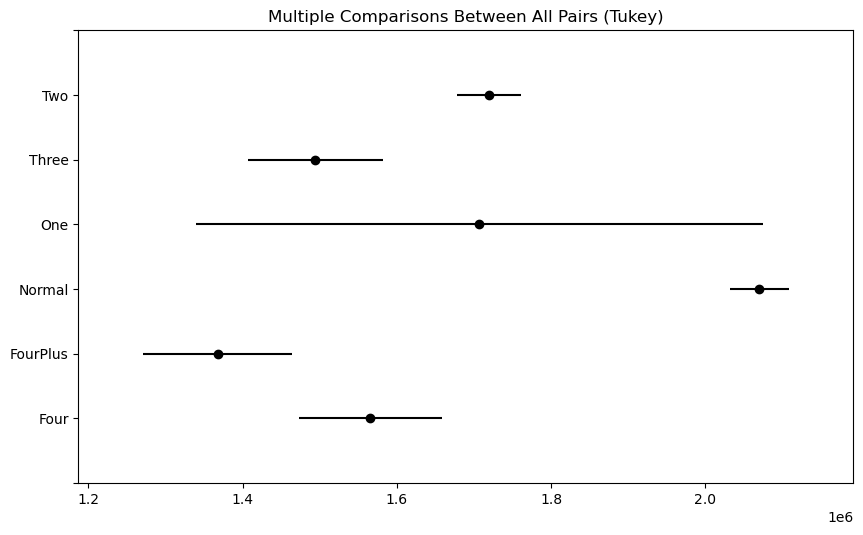

In [33]:
_ = mc.tukeyhsd().plot_simultaneous()

### Required Condition

#### Check normality assumption - Shapiro Wilk Test

$$H_0: \text{residual of all datapoints are normally distributed}$$  
$$H_1: \text{residual of all datapoints are not normally distributed}$$  

In [34]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.7783, p=0.0000


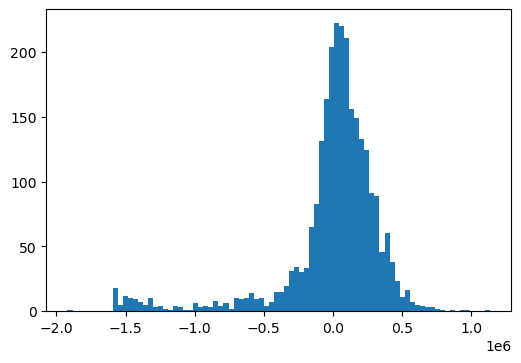

In [35]:
_ = plt.hist(results.resid, bins = "auto")

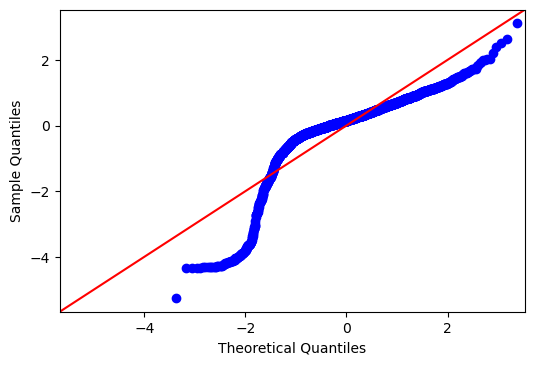

In [36]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.show()

### Nonparametric - Kruskal

In [50]:
alldata = np.array([])
for day in days_len:
    alldata = np.concatenate([alldata, day])
alldata.sort()
tmpdf = pd.DataFrame(({'value': alldata}))
tmpdf['rank'] = tmpdf.index + 1
value2rank = tmpdf.groupby('value').mean().reset_index()
value2rank

,value,rank
0,149936.0,1.0
1,150242.0,2.0
2,152420.0,3.0
3,160534.0,4.0
4,168154.0,5.0
...,...,...
2637,2658619.0,2643.0
2638,2668231.0,2644.0
2639,2678263.0,2645.0
2640,3028347.0,2646.0


In [55]:
T = []
for i, day in enumerate(days_len):
    samp = pd.DataFrame({'value': day})
    samp = pd.merge(samp, value2rank)
    T.append(samp['rank'].sum())
    print(f"T%s = {T[i]}"%(i))

T0 = 2910241.0
T1 = 3373.0
T2 = 513826.0
T3 = 32285.0
T4 = 27498.0
T5 = 17405.0


In [39]:
n = []
columns = ['Normal', 'One', 'Two', 'Three', 'Four', 'FourPlus']
for column in columns:
    n.append(df1[column].dropna().shape[0])
# print(n)
T = np.array(T)
n = np.array(n)
x = T ** 2 / n
k = 6
n = n.sum()
H = 12 / (n * (n + 1)) * (x.sum()) - 3 * (n + 1)
pvalue = 1 - stats.chi2.cdf(H, k - 1)

print(f"H = {H}")
print(f"p-value = {pvalue}")

H = 886.9305419389802
p-value = 0.0


## 情人節

In [40]:
valentines = [[] for i in range(12)]

In [41]:
year = np.arange(2015, 2023, 1)
month = np.arange(1, 13, 1)
for y in year:
    if(y == 2022):
        month = np.arange(1, 4, 1)
    for m in month:
        valentines[m - 1].append(transportCnt[datetime(y, m, 14)])

In [42]:
df1 = pd.DataFrame(valentines).T
month = np.arange(1, 13, 1)
month = ["TPcnt_" + str(m) for m in month]
df1.columns = month
df1.index = year
df1

,TPcnt_1,TPcnt_2,TPcnt_3,TPcnt_4,TPcnt_5,TPcnt_6,TPcnt_7,TPcnt_8,TPcnt_9,TPcnt_10,TPcnt_11,TPcnt_12
2015,1969032.0,1972064.0,2130819.0,2003426.0,2000535.0,1625054.0,2053764.0,2225728.0,2028392.0,2058401.0,2128618.0,2067831.0
2016,2132908.0,1571141.0,2075900.0,2114514.0,2060206.0,2020762.0,2139774.0,1751907.0,2009847.0,2375774.0,2061484.0,2164732.0
2017,1934888.0,2165802.0,2168801.0,2362235.0,1599230.0,2052846.0,2256065.0,2052866.0,2000767.0,1704860.0,2128134.0,2264764.0
2018,1644482.0,1987693.0,2228608.0,1989513.0,2089882.0,2171239.0,1957895.0,2197576.0,2372248.0,1763493.0,2238602.0,2562165.0
2019,2192358.0,2331604.0,2301836.0,1774276.0,2197050.0,2428458.0,1711032.0,2279835.0,1683910.0,2187500.0,2347845.0,2522817.0
2020,2342929.0,2147042.0,1456154.0,1714740.0,1908693.0,1342973.0,2111141.0,2222235.0,2056520.0,2171465.0,2013294.0,2163973.0
2021,2203013.0,1342891.0,1626631.0,2170091.0,1737951.0,176735.0,741813.0,743676.0,1446935.0,1765101.0,1306487.0,1960860.0
2022,2024999.0,1804237.0,1913369.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# 需要一個ID欄位
df1["id"] = df1.index
# 呼叫wide_to_long(); 文件請見: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html
df2 = pd.wide_to_long(df1, ["TPcnt"], sep="_", suffix='\w+', i="id", j="Month").reset_index()
df2 = df2.dropna()
print("Head of dataset:")
display(df2.head())
print("Tail of dataset:")
display(df2.tail())

Head of dataset:


,id,Month,TPcnt
0,2015,1,1969032.0
1,2016,1,2132908.0
2,2017,1,1934888.0
3,2018,1,1644482.0
4,2019,1,2192358.0


Tail of dataset:


,id,Month,TPcnt
90,2017,12,2264764.0
91,2018,12,2562165.0
92,2019,12,2522817.0
93,2020,12,2163973.0
94,2021,12,1960860.0


In [44]:
results = smf.ols('TPcnt ~ C(Month)', data=df2).fit()
# results.summary()
aov_table = sms.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Month),1.337335e+12,11.0,0.823141,0.617335
Residual,1.107732e+13,75.0,NaN,NaN


In [45]:
mc = smm.MultiComparison(df2['TPcnt'], df2['Month'])
# print(mc.tukeyhsd().summary())

### Required Condition

#### Check normality assumption - Shapiro Wilk Test

$$H_0: \text{residual of all datapoints are normally distributed}$$  
$$H_1: \text{residual of all datapoints are not normally distributed}$$  

In [46]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.8800, p=0.0000


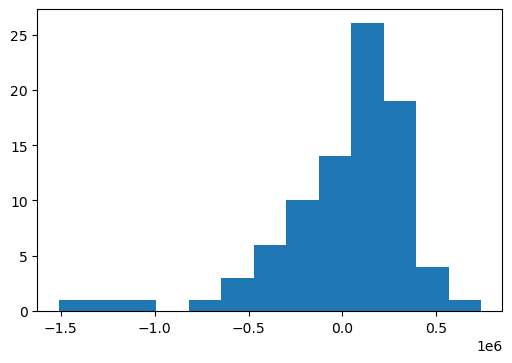

In [47]:
_ = plt.hist(results.resid, bins = "auto")

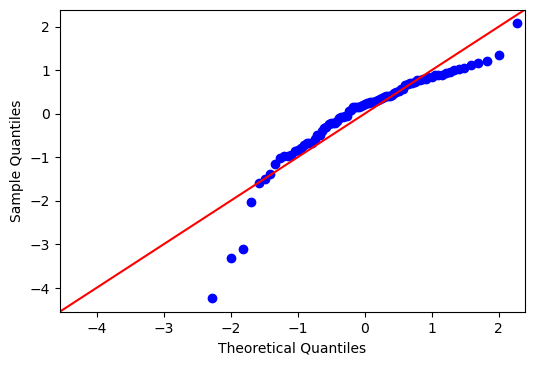

In [48]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.show()

#### Check equal variance assumption - Bartlett's Test

$$H_0: \text{Variance of different treatment groups are equal}$$  
$$H_1: \text{At least two treatment groups have different variance}$$

In [49]:
df2['resid'] = results.resid
stats.bartlett(df2['resid'][df2['Month'] == 1],
              df2['resid'][df2['Month'] == 2],
              df2['resid'][df2['Month'] == 3],
                df2['resid'][df2['Month'] == 4],
              df2['resid'][df2['Month'] == 5],
              df2['resid'][df2['Month'] == 6],
              df2['resid'][df2['Month'] == 7],
              df2['resid'][df2['Month'] == 8],
              df2['resid'][df2['Month'] == 9],
              df2['resid'][df2['Month'] == 10],
              df2['resid'][df2['Month'] == 11],
              df2['resid'][df2['Month'] == 12],
)

BartlettResult(statistic=25.659671277120232, pvalue=0.007290221213039214)